In [1]:
# Standard Library Imports
import os                       # Operating system functions
import subprocess               # Subprocess management
import random                   # Random number generation
from tqdm import tqdm           # Progress bars

# Data Manipulation and Visualization
import json                     # JSON data manipulation
import inspect                  # Inspection of live objects
import pandas as pd              # Data manipulation using DataFrames
import numpy as np               # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns            # Styling plots

# Image Processing
from PIL import Image            # Python Imaging Library for image processing

# Model Libraries
import timm                     # Used for pre-trained models such as EfficientNet, ViT

# PyTorch
import torch                    # PyTorch overall import
import torch.optim as optim     # Optimization of model parameters
import torch.nn as nn           # Specification of neural networks
from torch.utils.data import Dataset, DataLoader  # Data loading utilities
import torchvision.transforms as transforms      # Pre-processing data

c:\Users\Public\anaconda3\envs\SFAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    print("Using apple silicon mps device.")
elif torch.cuda.is_available():
    print("Using Nvidia cuda device.")
else:
    print("Using CPU.")

Using Nvidia cuda device.


### Define Configuration

In [3]:
class Config:
    _visualize_data = False

    # Reproducibility
    SEED = 42

    # Model Hyperparameters
    model_name = 'vit_large_patch16_224'                 # 'restnet_152', 'efficientnet_{b0, b1, ... , b7}', 'vit_base_path16_224', 'vit_large_patch16_224'
    _in_channels = 3                   # RGB images
    image_res = 64                     # Must be multiple of 256
    num_classes = 200
    pretrained_efficient_net = True
    # if model_name != 'vit' and model_name != 'resnet152' and int(model_name.split('_b')[-1]) >= 5:
    #     pretrained_efficient_net = False
    dropout_rate = 0                   # 0, 0.1, 0.5
    l2_regularization_strength = 0     # 0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
    batch_size = 128                   # change batch size to fit memory budget, set to 2 here for contrastive loss
    learning_rate = 1e-5               # 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
    epochs = 10

    # Loss
    use_contrastive = False
    lambda_contrastive = 10            # 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7

    # Data Paths
    _data_path = os.path.join(os.getcwd(), 'data')
    dataset = 'tiny-imagenet-200'
    _ds_path = os.path.join(_data_path, dataset)
    _data_csv_path = os.path.join(_ds_path, 'tinyimagenet.csv')

    # Saving Paths
    _result_dir = "results"
    _weight_dir = "weights"
    if not os.path.exists(_result_dir):
        os.makedirs(_result_dir)
    if not os.path.exists(_weight_dir):
        os.makedirs(_weight_dir)
    
    # File Names and Paths
    _model_fname = f"best_{model_name}_lr-{learning_rate}_dropout_rate-{dropout_rate}"
    _save_result_path = os.path.join(_result_dir, _model_fname)
    _save_weight_path = os.path.join(_weight_dir, f'{_model_fname}.pth')
    _dict = {}

config = Config()

### Construct Data Frame

In [4]:
if os.path.exists(config._data_csv_path):
    print('Loading existing data csv file')
    df = pd.read_csv(config._data_csv_path)
else:
    print('Creating data csv file')
    # specify the data path
    data_path = config._ds_path

    # Specify the words file name
    words_file_path = os.path.join(data_path, "words.txt")

    # Read data from the file
    with open(words_file_path, 'r') as file:
        words = file.read()

    # Split the data into lines
    lines = words.split('\n')

    # Construct the dictionary
    label2text = {}
    for line in lines:
        if line:
            key, value = line.split(maxsplit=1)
            label2text[key] = value

    # Print the resulting dictionary
    train_dir = os.path.join(data_path, 'train')
    val_dir = os.path.join(data_path, 'val')
    dirs = {'train': train_dir, 'val': val_dir}

    data_list = []
    for ds, ds_path in dirs.items():
        for label in os.listdir(ds_path):
            label_dir = os.path.join(ds_path, label)
            if os.path.isdir(label_dir):
                for image_path in os.listdir(label_dir):
                    if not image_path.split('.')[-1] == 'JPEG':
                        continue
                    image_path = os.path.join(label_dir, image_path)
                    data_list.append({
                    'image_path': image_path,
                    'set': ds,
                    'label': label,
                    'label-description': label2text[label]
                    })
    df = pd.DataFrame(data_list)
    df.to_csv(config._data_csv_path, index=False)
df.sample(n=5).head()

Loading existing data csv file


,image_path,set,label,label-description
35112,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n02814533,"beach wagon, station wagon, wagon, estate car,..."
66673,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n03977966,"police van, police wagon, paddy wagon, patrol ..."
86780,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n04562935,water tower
90952,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n07695742,pretzel
16107,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n02124075,Egyptian cat


### Investigate Dataset

In [5]:
def visualize_ds(df):
    # Get basic statistics about the dataset
    train_count = df['set'].value_counts().get('train', 0)
    val_count = df['set'].value_counts().get('val', 0)
    num_unique_labels = df['label'].nunique()
    unique_labels = df['label'].unique()
    label_counts = df['label'].value_counts()
    # Get the counts for the least and most common labels
    least_common_count = label_counts.min()
    most_common_count = label_counts.max()
    imb_ratio = least_common_count / most_common_count
    print("Count of training images:", train_count)
    print("Count of validation images:", val_count)
    print(f"Total number of images: {train_count + val_count}")
    print(f"Train test split ratio: {train_count/(train_count + val_count):.1f} :\
    {val_count/(train_count + val_count):.1f}")
    print(f"{num_unique_labels = }")

    # Plot the distribution of the target classes for both training and validation sets
    plt.figure(figsize=(12, 6))

    # Training set
    plt.subplot(1, 2, 1)
    sns.countplot(data=df[df['set'] == 'train'], x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes (Training Set)')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Validation set
    plt.subplot(1, 2, 2)
    sns.countplot(data=df[df['set'] == 'val'], x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes (Validation Set)')
    plt.xlabel('Label')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    print(f"Class imbalance ratio: {imb_ratio}")

if config._visualize_data: visualize_ds(df)

### Data Visualization

In [6]:
if config._visualize_data:
    random.seed(config.SEED)
    random_indices = random.sample(range(len(df)), 4)
    # Plot the images with increased spacing
    plt.figure(figsize=(7, 7))
    for i, index in enumerate(random_indices, 1):
        plt.subplot(2, 2, i)
        plt.imshow(plt.imread(df['image_path'].iloc[index]))
        plt.title(f"Label: {df['label-description'].iloc[index]}")

    plt.show()

### Perform one-hot encoding


In [7]:
# Perform one-hot encoding on the 'label' column
df_one_hot = pd.get_dummies(df["label"], prefix="label").astype(int)

# Extract columns from the original DataFrame excluding 'label'
exclude_columns = ['label']
additional_columns = df[[col for col in df.columns if col not in exclude_columns]]

# Concatenate the original DataFrame with the one-hot encoded labels
df_combined = pd.concat([df_one_hot, additional_columns], axis=1)

### Create a Pytorch Data Loading Pipeline

In [8]:
# Custom dataset class for loading images and corresponding labels
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of file paths to the images.
            labels (list): List of corresponding labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Returns the total number of samples in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is a PyTorch tensor and label is an integer.
        """
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Read and preprocess the image
        with open(image_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
train_labels = df_combined[df_combined['set'] == 'train'][[col for col in df_combined.columns if col.startswith("label_")]].values
val_labels = df_combined[df_combined['set'] == 'val'][[col for col in df_combined.columns if col.startswith("label_")]].values
train_paths = df_combined[df_combined['set'] == 'train']['image_path'].values
val_paths = df_combined[df_combined['set'] == 'val']['image_path'].values

assert(len(train_labels) == len(train_paths))
assert(len(val_labels) == len(val_paths))

# Define transformations
transform = transforms.Compose([
    transforms.Resize((config.image_res, config.image_res)),
    # transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # TODO: add other transformations...
])

# Create custom datasets
train_dataset = CustomDataset(train_paths, train_labels, transform=transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

### Build Models

In [10]:
        # self.emb_ext = nn.Linear(int(65792 * (config.image_res / 256)**2), config.image_res**2)


In [11]:
class simpleCNN_feat_encoder(nn.Module):
    def __init__(self):
        super(simpleCNN_feat_encoder, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(3)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))

        return x

class ResNet152(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_prob=0.5, isClassifier=True):
        """
        Initializes the ResNet152 model with drop out regularization.

        Args:
            in_channels (int): Number of input channels.
            num_classes (int): Number of output classes.
            dropout_prob (float): Dropout probability. Set to 0 to disable dropout.
        """
        super(ResNet152, self).__init__()
        self.isClassifier = isClassifier
        self.dropout_prob = dropout_prob
        self.in_channels = in_channels

        # Initial convolution block
        self.conv1 = self.conv_block(self.in_channels, 64)
        # Downsample with pooling
        self.conv2 = self.conv_block(64, 128, pool=True)
        # Residual blocks
        self.res1 = nn.Sequential(self.conv_block(128, 128),
                                  self.conv_block(128, 128))

        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512),
                                  self.conv_block(512, 512))

        self.conv5 = self.conv_block(512, 1028, pool=True)
        self.res3 = nn.Sequential(self.conv_block(1028, 1028),
                                  self.conv_block(1028, 1028))

        # Embedding extract
        # self.emb_ext = ...
        self.emb_ext = nn.Linear(int(65792 * (config.image_res / 256)**2), 3 * config.image_res**2)
        # Classifier
        self.classifier_pre = nn.Sequential(nn.MaxPool2d(2), nn.Flatten())
        self.classifier = nn.Linear(int(65792 * (config.image_res / 256)**2), num_classes)

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        res1_out = self.res1(out) + out

        out = self.conv3(res1_out)
        out = self.conv4(out)
        res2_out = self.res2(out) + out

        out = self.conv5(res2_out)
        res3_out = self.res3(out) + out
        out = self.classifier_pre(res3_out)
        if self.isClassifier:
            out = self.classifier(out)
            return out
        else:
            emb = self.emb_ext(out)
            return emb

    def conv_block(self, in_channels, out_channels, pool=False):
        """
        Defines a convolutional block with optional max pooling and dropout.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            pool (bool): Whether to include max pooling after convolution.
            dropout_prob (float): Dropout probability. Set to 0 to disable dropout.

        Returns:
            nn.Sequential: A sequential module representing the convolutional block.
        """
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        # Add dropout layer with the specified probability
        if self.dropout_prob > 0:
            layers.append(nn.Dropout2d(p=self.dropout_prob))

        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

def build_efficientnet(in_channels=3, num_classes=200):
    model = timm.create_model(config.model_name, pretrained=config.pretrained_efficient_net, in_chans=in_channels)
    # Modify the classifier to match the number of classes
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

class CustomViT(nn.Module):
    def __init__(self, cfg):
        super(CustomViT, self).__init__()
        # self.model = timm.create_model('vit_base_patch16_224', pretrained=False, **cfg)
        self.model = timm.create_model('vit_large_patch16_224', pretrained=True, **cfg)

    def forward(self, x):
        return self.model(x)

''' # Build a Custom efficientnetb3 model
class CustomEfficientNetB3(nn.Module):
    def __init__(self, num_classes=200, in_channels=3):
        super(CustomEfficientNetB3, self).__init__()

        # Load the pretrained EfficientNet-B6 model without the final classifier
        # Set pretrained=True if you want to use the weights from ImageNet pretraining
        self.base_model = timm.create_model('efficientnet_b3', pretrained=True)


        last_layer = nn.Sequential(*list(self.base_model.children()))[-1]
        # Remove the final classifier layer
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])

        # Get the number of output channels from the last layer of the base model
        last_in_channels = last_layer.in_features


        # # Change stride of two Conv2d layers to (1, 1)
        # for module in self.base_model.modules():
        #     if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
        #         module.stride = (1, 1)
            
        
        # Add a custom classification head
        self.last = nn.Sequential(
            nn.Conv2d(last_in_channels, 3072, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.last(x)
        return x'''

### Load Model

In [12]:
in_channels = config._in_channels  # Assuming RGB images
num_classes = config.num_classes  # Adjust as needed
dropout_rate = config.dropout_rate  # Adjust as needed

if config.model_name == 'resnet152':
    model = ResNet152(in_channels, num_classes, dropout_prob = dropout_rate)
elif config.model_name.split('_')[0] == 'efficientnet':
    model = build_efficientnet()
elif config.model_name == 'vit':
    custom_cfg = {
    # 'img_size': config.image_res,
    'img_size': 64,
    'patch_size': 16,            # default 16
    'in_chans': config._in_channels,
    'num_classes': config.num_classes,
    # Add other configuration options as needed
    }
    model = CustomViT(cfg=custom_cfg)


# feat_encoder = ResNet152(in_channels, num_classes, dropout_prob = dropout_rate, isClassifier=False)
feat_encoder = CustomEfficientNetB3()
print("Using CustomEfficientNetB3 as image feature encoder.")
print(f"Training a {config.model_name} model.")
# print(model)

Using CustomEfficientNetB3 as image feature encoder.
Training a vit model.


### Helper Functions

In [13]:
def accuracy(net, data_loader, task=None):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    # TODO: add tqdm for evaluation loop
    # for images, labels in data_loader:
    for images, labels in tqdm(data_loader, desc=f"Evaluating {task} accuracy", unit="batch", leave=False):
        if  torch.cuda.is_available():
            net = net.cuda()
            images = images.cuda()
            labels = labels.cuda()

        elif torch.backends.mps.is_available():
            mps_device = torch.device("mps")
            net.to(mps_device)
            images, labels = images.to(mps_device), labels.to(mps_device)

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        _, labels = torch.max(labels, 1)

        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count
    return correct / total

def plot_loss(Loss):
    plt.figure(figsize=(10,8))
    epochs = list(range(1, len(Loss) + 1))
    plt.plot(epochs, Loss, label=' Loss')
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    plt.legend()
    plt.xlim([1,max(epochs)])
    ''' !!!!! Change the plot title every time accordingly, or change the title and then
    re-run the plot history function at the end of training !!!!!'''
    plt.title(f'Loss records with Epoch={config.epochs}')

def plot_history(history):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        history: A dictionary storing information about the model trained.
        It should have the keys:
            * train_accs: A list of train accuracies
            * test_accs: A list of test accuracies.
    """
    plt.figure()
    epochs = list(range(1, len(history['train_accs']) + 1))
    val = plt.plot(epochs, history['val_accs'],
                     '--', label=' Test')
    plt.plot(epochs, history['train_accs'], color=val[0].get_color(),
               label=' Train')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])
    # Force x-axis ticks to be integers
    plt.xticks(list(epochs))
    plt.title(f'Accuracy results with Epoch={config.epochs}')

def save_plot(json_file):
    result_folder = "results"
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)
    
    plt.figure()
    # Read JSON data from file
    with open(json_file, 'r') as file:
        json_data = json.load(file)

    # Extracting data
    epochs = range(1, json_data["Num-Epochs"] + 1)
    train_accs = json_data["train_accs"]
    val_accs = json_data["val_accs"]

    # Plotting
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Set y-axis limit to 1
    plt.ylim(0, 1)
    # Force x-axis ticks to be integers
    plt.xticks(list(epochs))

    # Save the plot to a JPG file with the same name as the JSON file
    jpg_file = json_file.replace('.json', '.jpg')
    plt.savefig(jpg_file)

    # Close the plot without displaying it
    plt.close()

def train_loop(model, train_loader, val_loader, config):
    if torch.cuda.is_available():
        model = model.cuda()

    elif torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)

    classification_criterion = nn.CrossEntropyLoss()
    # if config.use_contrastive:
    #     contrastive_criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate,
                          weight_decay=config.l2_regularization_strength)

    train_accs = []
    val_accs = []
    losses = []
    best_val_acc = 0.0  # Initialize the best validation accuracy
    best_epoch = 0      # Initialize the epoch where the best accuracy occurred

    for epoch in range(1, config.epochs + 1):
        model.train()
        total_batches = len(train_loader)
        train_loader_with_progress = tqdm(train_loader, total=total_batches, desc=f'Epoch {epoch}/{config.epochs}')

        for inputs, labels in train_loader_with_progress:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            elif torch.backends.mps.is_available():
                mps_device = torch.device("mps")
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(f'Outputs shape: {outputs.shape}')
            # print(f'Labels shape: {labels.shape}')
            # print(f'Embeddings shape: {embs.shape}')

            # Compute the classification loss
            classification_loss = classification_criterion(outputs.float(), labels.float())
            total_loss = classification_loss

            # # Compute the contrastive loss
            # if config.use_contrastive:
            #     assert(len(embs) >= 2)
            #     positive_emb, negative_emb = embs[0], embs[1]
            #     contrastive_labels = labels[1]  # Assuming labels[1] contains the contrastive labels
            #     contrastive_loss = contrastive_criterion(positive_emb, negative_emb, contrastive_labels.float(), dist='cosine')

            #     # Combine the losses (you can adjust the weights as needed)
            #     total_loss += config.lambda_contrastive * contrastive_loss


            # continue
            total_loss.backward()
            optimizer.step()

            losses.append(total_loss.item())
        # continue
        model.eval()
        # print("Evaluating training accuracy")
        train_acc = accuracy(model, train_loader, task='training')
        # print("Evaluating validation accuracy")
        val_acc = accuracy(model, val_loader, task='validaiton')
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch}/{config.epochs}], Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Loss: {total_loss:.4f}')

        # Check if the current model has the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

            # Save the model weights
            torch.save(model.state_dict(), f'{config._save_weight_path}.pth')

    print(f'Best Validation Accuracy of {best_val_acc:.4f} achieved at Epoch {best_epoch}')
    return train_accs, val_accs, losses


def train_loop_with_feat_encoder(feat_encoder, model, train_loader, val_loader, config):
    if torch.cuda.is_available():
        feat_encoder = feat_encoder.cuda()
        model = model.cuda()
    elif torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        feat_encoder.to(mps_device)
        model.to(mps_device)

    classification_criterion = nn.CrossEntropyLoss()
    # if config.use_contrastive:
    #     contrastive_criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate,
                          weight_decay=config.l2_regularization_strength)

    train_accs = []
    val_accs = []
    losses = []
    best_val_acc = 0.0  # Initialize the best validation accuracy
    best_epoch = 0      # Initialize the epoch where the best accuracy occurred

    for epoch in range(1, config.epochs + 1):
        model.train()
        total_batches = len(train_loader)
        train_loader_with_progress = tqdm(train_loader, total=total_batches, desc=f'Epoch {epoch}/{config.epochs}')

        for inputs, labels in train_loader_with_progress:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            elif torch.backends.mps.is_available():
                mps_device = torch.device("mps")
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)

            optimizer.zero_grad()

            # Get feature embedding of image with CNN, reshape to original image shape
            feat_emb = feat_encoder(inputs)
            feat_emb = feat_emb.view_as(inputs)
            # Classify with ViT
            outputs = model(feat_emb)
            
            # # Check dimensions
            # print(f'Outputs shape: {outputs.shape}')
            # print(f'Labels shape: {labels.shape}')
            # print(f'Inputs shape: {inputs.shape}')

            # Compute the classification loss
            classification_loss = classification_criterion(outputs.float(), labels.float())
            total_loss = classification_loss

            # # Compute the contrastive loss
            # if config.use_contrastive:
            #     assert(len(embs) >= 2)
            #     positive_emb, negative_emb = embs[0], embs[1]
            #     contrastive_labels = labels[1]  # Assuming labels[1] contains the contrastive labels
            #     contrastive_loss = contrastive_criterion(positive_emb, negative_emb, contrastive_labels.float(), dist='cosine')

            #     # Combine the losses (you can adjust the weights as needed)
            #     total_loss += config.lambda_contrastive * contrastive_loss


            # continue
            total_loss.backward()
            optimizer.step()

            losses.append(total_loss.item())
        # continue
        model.eval()
        # print("Evaluating training accuracy")
        train_acc = accuracy(model, train_loader, task='training')
        # print("Evaluating validation accuracy")
        val_acc = accuracy(model, val_loader, task='validaiton')
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch}/{config.epochs}], Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Loss: {total_loss:.4f}')

        # Check if the current model has the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

            # Save the model weights
            torch.save(model.state_dict(), config._save_weight_path)

    print(f'Best Validation Accuracy of {best_val_acc:.4f} achieved at Epoch {best_epoch}')
    return train_accs, val_accs, losses


### Train the model

In [14]:
train_accs, val_accs, losses = train_loop(model, train_loader, val_loader, config)
# train_accs, val_accs, losses = train_loop_with_feat_encoder(feat_encoder, model, train_loader, val_loader, config)

Epoch 1/15: 100%|██████████| 782/782 [10:52<00:00,  1.20it/s]


Epoch [1/15], Train Accuracy: 0.7715, Val Accuracy: 0.7004, Loss: 1.2929


Epoch 2/15: 100%|██████████| 782/782 [04:54<00:00,  2.66it/s]


Epoch [2/15], Train Accuracy: 0.9111, Val Accuracy: 0.7455, Loss: 0.3146


Epoch 3/15: 100%|██████████| 782/782 [04:54<00:00,  2.66it/s]


Epoch [3/15], Train Accuracy: 0.9767, Val Accuracy: 0.7523, Loss: 0.3023


Epoch 4/15: 100%|██████████| 782/782 [04:43<00:00,  2.76it/s]


Epoch [4/15], Train Accuracy: 0.9962, Val Accuracy: 0.7545, Loss: 0.0164


Epoch 5/15: 100%|██████████| 782/782 [04:43<00:00,  2.76it/s]


Epoch [5/15], Train Accuracy: 0.9993, Val Accuracy: 0.7583, Loss: 0.0123


Epoch 6/15: 100%|██████████| 782/782 [04:44<00:00,  2.75it/s]


Epoch [6/15], Train Accuracy: 0.9996, Val Accuracy: 0.7614, Loss: 0.0039


Epoch 7/15: 100%|██████████| 782/782 [04:54<00:00,  2.65it/s]


Epoch [7/15], Train Accuracy: 0.9998, Val Accuracy: 0.7612, Loss: 0.0025


Epoch 8/15: 100%|██████████| 782/782 [04:54<00:00,  2.65it/s]


Epoch [8/15], Train Accuracy: 0.9719, Val Accuracy: 0.7260, Loss: 0.0508


Epoch 9/15: 100%|██████████| 782/782 [04:53<00:00,  2.66it/s]


Epoch [9/15], Train Accuracy: 0.9954, Val Accuracy: 0.7507, Loss: 0.0228


Epoch 10/15: 100%|██████████| 782/782 [04:44<00:00,  2.75it/s]


Epoch [10/15], Train Accuracy: 0.9979, Val Accuracy: 0.7521, Loss: 0.0172


Epoch 11/15: 100%|██████████| 782/782 [04:43<00:00,  2.76it/s]


Epoch [11/15], Train Accuracy: 0.9989, Val Accuracy: 0.7545, Loss: 0.0062


Epoch 12/15: 100%|██████████| 782/782 [04:43<00:00,  2.76it/s]


Epoch [12/15], Train Accuracy: 0.9974, Val Accuracy: 0.7528, Loss: 0.0010


Epoch 13/15: 100%|██████████| 782/782 [04:43<00:00,  2.76it/s]


Epoch [13/15], Train Accuracy: 0.9945, Val Accuracy: 0.7434, Loss: 0.0101


Epoch 14/15: 100%|██████████| 782/782 [04:43<00:00,  2.76it/s]


Epoch [14/15], Train Accuracy: 0.9969, Val Accuracy: 0.7541, Loss: 0.0032


Epoch 15/15: 100%|██████████| 782/782 [04:46<00:00,  2.73it/s]
                                                                                  

Epoch [15/15], Train Accuracy: 0.9976, Val Accuracy: 0.7480, Loss: 0.0016
Best Validation Accuracy of 0.7614 achieved at Epoch 6


### Visualize and Save Results

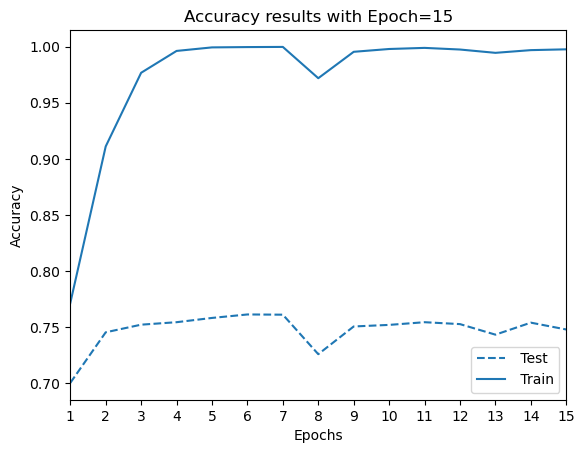

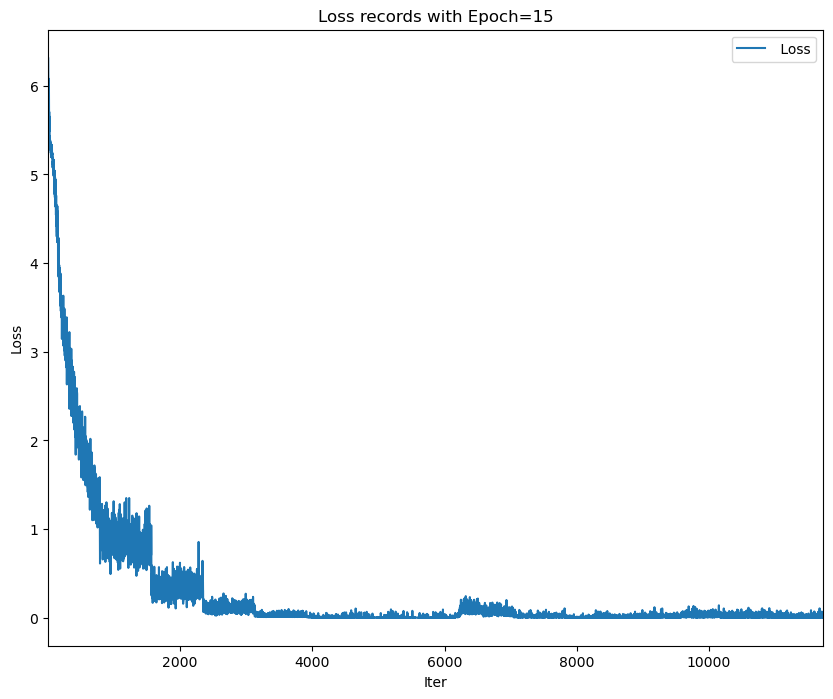

In [15]:
history = {}
# Add config values to the history dictionary
for i in inspect.getmembers(config):
    # to remove private and protected
    # functions
    if not i[0].startswith('_'):
        # To remove other methods that
        # doesnot start with a underscore
        if not inspect.ismethod(i[1]):
            key, value = i
            config._dict[key] = value
history['config'] = config._dict
history['train_accs'] = train_accs
history['val_accs'] = val_accs
history['Num-Epochs'] = len(history['val_accs'])
plot_history(history)
plot_loss(losses)

# Save json and plot
with open(config._save_result_path+".json", 'w') as json_file:
    json.dump(history, json_file)
save_plot(config._save_result_path+".json")


In [16]:
config._dict

{'SEED': 42,
 'batch_size': 128,
 'dataset': 'tiny-imagenet-200',
 'dropout_rate': 0,
 'epochs': 15,
 'image_res': 64,
 'l2_regularization_strength': 0,
 'lambda_contrastive': 10,
 'learning_rate': 1e-05,
 'model_name': 'vit',
 'num_classes': 200,
 'pretrained_efficient_net': True,
 'use_contrastive': False}